In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    balanced_accuracy_score
)
from sklearn.impute import SimpleImputer
import joblib

# SMOTE for class balancing
from imblearn.over_sampling import SMOTE

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [2]:
def load_and_clean_data():
    # Load dataset
    df = pd.read_csv("boxing_data.csv")

    # Convert Result column (binary target)
    df["Result"] = df["Result"].apply(lambda x: 1 if x == 1 else 0)

    print(df["Result"].value_counts(normalize=True))

    numeric_cols = [
        "ReachA","ReachB","HeightA","HeightB","WeightA","WeightB",
        "AgeA","AgeB","WinsA","WinsB","KOPercA","KOPercB",
        "RecentWinPercA","RecentWinPercB","DefensePercA","DefensePercB",
        "PunchAccuracyA","PunchAccuracyB","StrengthOfScheduleA","StrengthOfScheduleB",
        "TimeSinceLastFightA","TimeSinceLastFightB","Result"
    ]

    # Convert to numeric (errors → NaN)
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Drop rows with missing target
    df = df.dropna(subset=["Result"])
    return df

df = load_and_clean_data()
logging.info(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

INFO: Dataset loaded with 304 rows and 47 columns


Result
1    0.634868
0    0.365132
Name: proportion, dtype: float64


,FighterA,FighterB,ReachA,ReachB,HeightA,HeightB,WeightA,WeightB,AgeA,AgeB,...,AvgOpponentWinPercB,StrengthOfScheduleA,StrengthOfScheduleB,StanceA,StanceB,WeightClassA,WeightClassB,TitleFight,LocationAdvantage,Result
0,Dmitry Bivol,Canelo Alvarez,72.0,70.0,72.0,68.0,174.0,174.0,31,31,...,0.78,8.0,10.0,Orthodox,Orthodox,LightHeavyweight,LightHeavyweight,1,0.0,1
1,Muhammad Ali,Joe Frazier,80.0,73.0,75.0,71.5,215.0,205.5,29,27,...,0.74,10.0,9.0,Orthodox,Orthodox,Heavyweight,Heavyweight,1,0.0,0
2,Thomas Hearns,Marvin Hagler,78.0,75.0,73.0,69.0,159.5,159.0,26,30,...,0.76,9.0,10.0,Orthodox,Southpaw,Middleweight,Middleweight,1,0.0,0
3,Floyd Mayweather,Manny Pacquiao,72.0,67.0,68.0,65.0,146.0,145.0,38,36,...,0.76,10.0,10.0,Orthodox,Southpaw,Welterweight,Welterweight,1,0.0,1
4,Lennox Lewis,Vitali Klitschko,84.0,79.0,77.0,79.0,256.5,248.5,37,31,...,0.72,10.0,9.0,Orthodox,Orthodox,Heavyweight,Heavyweight,1,0.0,1


In [3]:
def engineer_features(df):
    df["ReachDiff"] = df["ReachA"] - df["ReachB"]
    df["AgeDiff"] = df["AgeA"] - df["AgeB"]
    df["HeightDiff"] = df["HeightA"] - df["HeightB"]
    df["WeightDiff"] = df["WeightA"] - df["WeightB"]
    df["KODiff"] = df["KOPercA"] - df["KOPercB"]
    df["WinDiff"] = df["WinsA"] - df["WinsB"]
    df["RecentWinPercDiff"] = df["RecentWinPercA"] - df["RecentWinPercB"]
    df["DefenseDiff"] = df["DefensePercA"] - df["DefensePercB"]
    df["PunchAccDiff"] = df["PunchAccuracyA"] - df["PunchAccuracyB"]
    df["SoSDiff"] = df["StrengthOfScheduleA"] - df["StrengthOfScheduleB"]
    df["TimeSinceDiff"] = df["TimeSinceLastFightA"] - df["TimeSinceLastFightB"]

    feature_cols = [
        "ReachDiff","AgeDiff","HeightDiff","WeightDiff",
        "KODiff","WinDiff","RecentWinPercDiff",
        "DefenseDiff","PunchAccDiff","SoSDiff","TimeSinceDiff"
    ]
    return df, feature_cols

df, feature_cols = engineer_features(df)

In [4]:
X = df[feature_cols]
y = df["Result"]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)

# Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

logging.info(f"Before SMOTE: {y_train.value_counts().to_dict()}")
logging.info(f"After SMOTE: {y_train_res.value_counts().to_dict()}")

INFO: Before SMOTE: {1: 154, 0: 89}
INFO: After SMOTE: {0: 154, 1: 154}


In [5]:
model = make_pipeline(
    imputer,
    RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        class_weight=None,   # SMOTE balances classes
        min_samples_split=5
    )
)

model.fit(X_train_res, y_train_res)

print("Train accuracy:", model.score(X_train_res, y_train_res))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.987012987012987
Test accuracy: 0.8524590163934426



Confusion Matrix:
 [[14  8]
 [ 1 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76        22
           1       0.83      0.97      0.89        39

    accuracy                           0.85        61
   macro avg       0.88      0.81      0.83        61
weighted avg       0.86      0.85      0.84        61

Accuracy: 0.8524590163934426
Balanced Accuracy: 0.8053613053613053
ROC AUC: 0.9079254079254079


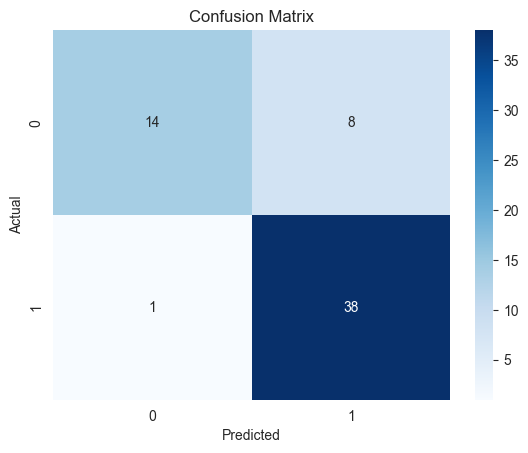

In [13]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", model.score(X_test, y_test))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba[:, 1]))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

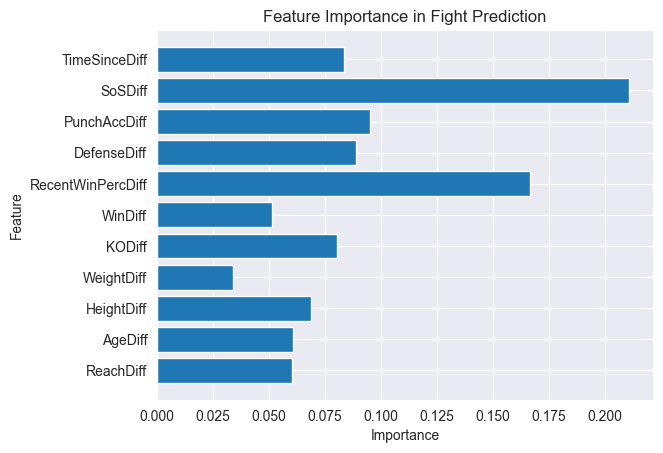

In [7]:
rf = model.named_steps["randomforestclassifier"]
importances = rf.feature_importances_

plt.barh(feature_cols, importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Fight Prediction")
plt.show()

In [8]:
fighters_stats = {}

for _, row in df.iterrows():
    fighters_stats[row["FighterA"]] = {
        "Reach": row["ReachA"], "Age": row["AgeA"], "Height": row["HeightA"],
        "Weight": row["WeightA"], "KO%": row["KOPercA"], "Wins": row["WinsA"],
        "RecentWin%": row["RecentWinPercA"], "Defense%": row["DefensePercA"],
        "PunchAcc": row["PunchAccuracyA"], "SoS": row["StrengthOfScheduleA"],
        "TimeSince": row["TimeSinceLastFightA"]
    }
    fighters_stats[row["FighterB"]] = {
        "Reach": row["ReachB"], "Age": row["AgeB"], "Height": row["HeightB"],
        "Weight": row["WeightB"], "KO%": row["KOPercB"], "Wins": row["WinsB"],
        "RecentWin%": row["RecentWinPercB"], "Defense%": row["DefensePercB"],
        "PunchAcc": row["PunchAccuracyB"], "SoS": row["StrengthOfScheduleB"],
        "TimeSince": row["TimeSinceLastFightB"]
    }

In [14]:
def predict_fight(fighterA, fighterB, model, fighters_stats):
    if fighterA not in fighters_stats or fighterB not in fighters_stats:
        raise ValueError("One or both fighters not found in dataset")

    statsA, statsB = fighters_stats[fighterA], fighters_stats[fighterB]

    features = {
        "ReachDiff": statsA["Reach"] - statsB["Reach"],
        "AgeDiff": statsA["Age"] - statsB["Age"],
        "HeightDiff": statsA["Height"] - statsB["Height"],
        "WeightDiff": statsA["Weight"] - statsB["Weight"],
        "KODiff": statsA["KO%"] - statsB["KO%"],
        "WinDiff": statsA["Wins"] - statsB["Wins"],
        "RecentWinPercDiff": statsA["RecentWin%"] - statsB["RecentWin%"],
        "DefenseDiff": statsA["Defense%"] - statsB["Defense%"],
        "PunchAccDiff": statsA["PunchAcc"] - statsB["PunchAcc"],
        "SoSDiff": statsA["SoS"] - statsB["SoS"],
        "TimeSinceDiff": statsA["TimeSince"] - statsB["TimeSince"]
    }

    X_pred = pd.DataFrame([features])
    pred = model.predict(X_pred)[0]
    prob = model.predict_proba(X_pred)[0]

    winner = fighterA if pred == 1 else fighterB
    confidence = prob[int(pred)]
    return winner, confidence

# Example
winner, confidence = predict_fight("Mike Tyson", "Muhammad Ali", model, fighters_stats)
print(f"Predicted winner: {winner} (Confidence: {confidence:.2f})")

Predicted winner: Mike Tyson (Confidence: 0.54)
